In [1]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 451 kB/s 


In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
import calendar
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
rcParams['figure.figsize'] = 20, 10

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Задача 1:
- Проведите аналитику полученных данных
- Подготовьте данные для регрессионной модели
- Обучите регрессионную модель и осуществите прогноз на последний месяц для поля SALES
- Оцените качество модели с помощью функции metric

## Метрика для оценки модели¶


In [64]:
def metric(y_true, y_pred):
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

In [193]:
def OneHotEncoding(df, feat):
    '''Функция производит Encoding'''
    print(df[feat].dtype)
    if df[feat].dtype == 'category' and feat != 'SALES':
        df = pd.concat([df, pd.get_dummies(df[feat], prefix=(feat+'_M'))], axis=1)
        df.drop(feat, axis=1, inplace=True)
    return df

def ARTICLE_CODE (df_test, df_new_train):
    for i in range(len(df_test)):
        if df_test.iloc[i,1] in df_train.ARTICLE_CODE.to_list():
            ind = df_train[df_train.ARTICLE_CODE == df_test.iloc[i,1]].index.to_list()
            mn = df_new_train.iloc[ind,1].mean()
            df_test.iloc[i,1] = mn
        else:
            df_test.iloc[i,1] = df_new_train.ARTICLE_CODE.mean()
    return df_test

def CONTRAGENT(df_test, df_new_train):
    for i in range(len(df_test)):
        if df_test.iloc[i,0] in df_train.CONTRAGENT.to_list():
            ind = df_train[df_train.CONTRAGENT == df_test.iloc[i,0]].index.to_list()
            mn = df_new_train.iloc[ind,0].mean()
            df_test.iloc[i,0] = mn
        else:
            df_test.iloc[i,0] = df_new_train.CONTRAGENT.mean()
    return df_test

In [65]:
df = pd.read_csv(r'/content/drive/MyDrive/Elbrus/data_regression_for_task.csv')
df

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0
...,...,...,...,...,...,...,...,...
128350,2018,2,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,66460.0,212.0
128351,2018,2,COASTAL BREWING COMPANY LLC,99970,DOMINION OAK BARREL STOUT 4/6 NR - 12OZ,BEER,9080.0,35.0
128352,2018,2,BOSTON BEER CORPORATION,99988,SAM ADAMS COLD SNAP 1/6 KG,KEGS,0.0,32.0
128353,2018,2,NaN,BC,BEER CREDIT,REF,0.0,-35.0


In [66]:
df.shape # Размер датафрейма

(128355, 8)

In [67]:
df.isnull().sum() # Пропущенные значения

YEAR              0
MONTH             0
CONTRAGENT       24
ARTICLE_CODE      0
ARTICLE_NAME      0
ARTICLE_GROUP     1
SALES             0
STORE_SALES       0
dtype: int64

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


In [69]:
# ОСоздаем переменную DATE
df['MONTH'] = df['MONTH'].apply(lambda x: calendar.month_abbr[x])
df['DATE'] = pd.to_datetime([f'{y}-{m}-01' for y, m in zip(df.YEAR, df.MONTH)])
df.drop(['YEAR', 'MONTH','ARTICLE_NAME'], 1, inplace=True)
df

,CONTRAGENT,ARTICLE_CODE,ARTICLE_GROUP,SALES,STORE_SALES,DATE
0,ROYAL WINE CORP,100200,WINE,0.0,0.0,2017-04-01
1,SANTA MARGHERITA USA INC,100749,WINE,0.0,0.0,2017-04-01
2,JIM BEAM BRANDS CO,10103,LIQUOR,0.0,0.0,2017-04-01
3,HEAVEN HILL DISTILLERIES INC,10120,LIQUOR,0.0,0.0,2017-04-01
4,ROYAL WINE CORP,101664,WINE,0.0,0.0,2017-04-01
...,...,...,...,...,...,...
128350,ANHEUSER BUSCH INC,9997,BEER,66460.0,212.0,2018-02-01
128351,COASTAL BREWING COMPANY LLC,99970,BEER,9080.0,35.0,2018-02-01
128352,BOSTON BEER CORPORATION,99988,KEGS,0.0,32.0,2018-02-01
128353,NaN,BC,REF,0.0,-35.0,2018-02-01


In [70]:
df[df.CONTRAGENT.isnull()]

,CONTRAGENT,ARTICLE_CODE,ARTICLE_GROUP,SALES,STORE_SALES,DATE
19483,NaN,1279,DUNNAGE,0.0,-9.0,2017-06-01
20056,NaN,1279,DUNNAGE,0.0,-5.0,2017-08-01
32282,NaN,BC,REF,0.0,-58.0,2017-06-01
32283,NaN,WC,REF,0.0,-8.0,2017-06-01
45871,NaN,BC,REF,0.0,-699.0,2017-08-01
45872,NaN,WC,REF,0.0,-5.0,2017-08-01
46518,NaN,1279,DUNNAGE,0.0,-9.0,2017-09-01
59259,NaN,BC,REF,0.0,-502.0,2017-09-01
59260,NaN,WC,REF,0.0,-15.0,2017-09-01
59920,NaN,1279,DUNNAGE,0.0,-6.0,2017-10-01


In [71]:
df[df.ARTICLE_GROUP.isnull()]

,CONTRAGENT,ARTICLE_CODE,ARTICLE_GROUP,SALES,STORE_SALES,DATE
66439,REPUBLIC NATIONAL DISTRIBUTING CO,347939,NaN,0.0,1.0,2017-10-01


In [72]:
df.dropna(subset=['ARTICLE_GROUP'], inplace=True)

In [73]:
# Применение LabelEncoder
le = LabelEncoder()
df.ARTICLE_GROUP = le.fit_transform(df.ARTICLE_GROUP)
df.ARTICLE_GROUP = df.ARTICLE_GROUP.astype('category')

In [74]:
# Применение OneHotEncoding
df = OneHotEncoding(df, 'ARTICLE_GROUP')
df

category


,CONTRAGENT,ARTICLE_CODE,SALES,STORE_SALES,DATE,ARTICLE_GROUP_M_0,ARTICLE_GROUP_M_1,ARTICLE_GROUP_M_2,ARTICLE_GROUP_M_3,ARTICLE_GROUP_M_4,ARTICLE_GROUP_M_5,ARTICLE_GROUP_M_6,ARTICLE_GROUP_M_7
0,ROYAL WINE CORP,100200,0.0,0.0,2017-04-01,0,0,0,0,0,0,0,1
1,SANTA MARGHERITA USA INC,100749,0.0,0.0,2017-04-01,0,0,0,0,0,0,0,1
2,JIM BEAM BRANDS CO,10103,0.0,0.0,2017-04-01,0,0,0,1,0,0,0,0
3,HEAVEN HILL DISTILLERIES INC,10120,0.0,0.0,2017-04-01,0,0,0,1,0,0,0,0
4,ROYAL WINE CORP,101664,0.0,0.0,2017-04-01,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128350,ANHEUSER BUSCH INC,9997,66460.0,212.0,2018-02-01,1,0,0,0,0,0,0,0
128351,COASTAL BREWING COMPANY LLC,99970,9080.0,35.0,2018-02-01,1,0,0,0,0,0,0,0
128352,BOSTON BEER CORPORATION,99988,0.0,32.0,2018-02-01,0,0,1,0,0,0,0,0
128353,NaN,BC,0.0,-35.0,2018-02-01,0,0,0,0,0,1,0,0


In [75]:
df.dropna(inplace=True)

In [76]:
# создаем train & test датасеты
df_train = df[df.DATE != '2017-04-01']
df_test = df[df.DATE == '2017-04-01']
df_train

,CONTRAGENT,ARTICLE_CODE,SALES,STORE_SALES,DATE,ARTICLE_GROUP_M_0,ARTICLE_GROUP_M_1,ARTICLE_GROUP_M_2,ARTICLE_GROUP_M_3,ARTICLE_GROUP_M_4,ARTICLE_GROUP_M_5,ARTICLE_GROUP_M_6,ARTICLE_GROUP_M_7
2689,DOPS INC,12644,0.0,1.0,2017-05-01,0,0,0,0,0,0,0,1
2913,Default,59978,250.0,0.0,2017-10-01,0,0,0,0,0,1,0,0
2989,DOPS INC,7102,0.0,11.0,2017-10-01,1,0,0,0,0,0,0,0
3547,LEGENDS LTD,8214,0.0,2.0,2017-10-01,1,0,0,0,0,0,0,0
3732,LEGENDS LTD,99090,0.0,1.0,2017-10-01,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128348,LEGENDS LTD,99753,0.0,2.0,2018-02-01,1,0,0,0,0,0,0,0
128349,COASTAL BREWING COMPANY LLC,99813,0.0,2.0,2018-02-01,0,0,1,0,0,0,0,0
128350,ANHEUSER BUSCH INC,9997,66460.0,212.0,2018-02-01,1,0,0,0,0,0,0,0
128351,COASTAL BREWING COMPANY LLC,99970,9080.0,35.0,2018-02-01,1,0,0,0,0,0,0,0


In [77]:
df_test

,CONTRAGENT,ARTICLE_CODE,SALES,STORE_SALES,DATE,ARTICLE_GROUP_M_0,ARTICLE_GROUP_M_1,ARTICLE_GROUP_M_2,ARTICLE_GROUP_M_3,ARTICLE_GROUP_M_4,ARTICLE_GROUP_M_5,ARTICLE_GROUP_M_6,ARTICLE_GROUP_M_7
0,ROYAL WINE CORP,100200,0.0,0.0,2017-04-01,0,0,0,0,0,0,0,1
1,SANTA MARGHERITA USA INC,100749,0.0,0.0,2017-04-01,0,0,0,0,0,0,0,1
2,JIM BEAM BRANDS CO,10103,0.0,0.0,2017-04-01,0,0,0,1,0,0,0,0
3,HEAVEN HILL DISTILLERIES INC,10120,0.0,0.0,2017-04-01,0,0,0,1,0,0,0,0
4,ROYAL WINE CORP,101664,0.0,0.0,2017-04-01,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5197,DIAGEO NORTH AMERICA INC,99228,0.0,0.0,2017-04-01,0,0,0,0,1,0,0,0
5198,DOPS INC,99260,0.0,0.0,2017-04-01,1,0,0,0,0,0,0,0
5199,HAMCO DC,9938,0.0,0.0,2017-04-01,0,0,0,0,0,0,1,0
5200,ANHEUSER BUSCH INC,9997,0.0,0.0,2017-04-01,1,0,0,0,0,0,0,0


In [78]:
df_train.corr()

,SALES,STORE_SALES,ARTICLE_GROUP_M_0,ARTICLE_GROUP_M_1,ARTICLE_GROUP_M_2,ARTICLE_GROUP_M_3,ARTICLE_GROUP_M_4,ARTICLE_GROUP_M_5,ARTICLE_GROUP_M_6,ARTICLE_GROUP_M_7
SALES,1.000000,0.459683,0.083614,-0.003238,-0.040465,0.085105,0.016822,0.000808,0.003346,-0.118202
STORE_SALES,0.459683,1.000000,0.204899,-0.109064,-0.008324,-0.048163,-0.002414,-0.001607,-0.002700,-0.093726
ARTICLE_GROUP_M_0,0.083614,0.204899,1.000000,-0.005359,-0.066968,-0.201839,-0.026312,-0.006379,-0.010721,-0.489723
ARTICLE_GROUP_M_1,-0.003238,-0.109064,-0.005359,1.000000,-0.002436,-0.007343,-0.000957,-0.000232,-0.000390,-0.017815
ARTICLE_GROUP_M_2,-0.040465,-0.008324,-0.066968,-0.002436,1.000000,-0.091758,-0.011962,-0.002900,-0.004874,-0.222632
ARTICLE_GROUP_M_3,0.085105,-0.048163,-0.201839,-0.007343,-0.091758,1.000000,-0.036052,-0.008740,-0.014689,-0.671002
ARTICLE_GROUP_M_4,0.016822,-0.002414,-0.026312,-0.000957,-0.011962,-0.036052,1.000000,-0.001139,-0.001915,-0.087473
ARTICLE_GROUP_M_5,0.000808,-0.001607,-0.006379,-0.000232,-0.002900,-0.008740,-0.001139,1.000000,-0.000464,-0.021205
ARTICLE_GROUP_M_6,0.003346,-0.002700,-0.010721,-0.000390,-0.004874,-0.014689,-0.001915,-0.000464,1.000000,-0.035641
ARTICLE_GROUP_M_7,-0.118202,-0.093726,-0.489723,-0.017815,-0.222632,-0.671002,-0.087473,-0.021205,-0.035641,1.000000


In [79]:
# Применение TargetEncoding 
from category_encoders.target_encoder import TargetEncoder
te = TargetEncoder()
df_new_train= te.fit_transform(df_train[['ARTICLE_CODE', 'CONTRAGENT']], df_train.SALES)
df_new_train.reset_index(drop = True, inplace = True)

In [80]:
df_new_train

,ARTICLE_CODE,CONTRAGENT
0,45.787540,428.843977
1,1205.985003,14685.747126
2,113.368068,428.843977
3,324.452775,700.306782
4,6.232739,700.306782
...,...,...
123130,110.035852,700.306782
123131,45.787540,2999.893617
123132,87928.353866,20790.981925
123133,13135.666240,2999.893617


In [81]:
df_train.reset_index(drop = True, inplace=True)

In [82]:
# Применяем данные, полученные на TargetEncoding на тестовом датасете
df_test = ARTICLE_CODE(df_test, df_new_train)
df_test = CONTRAGENT(df_test, df_new_train)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [83]:
df_test

,CONTRAGENT,ARTICLE_CODE,SALES,STORE_SALES,DATE,ARTICLE_GROUP_M_0,ARTICLE_GROUP_M_1,ARTICLE_GROUP_M_2,ARTICLE_GROUP_M_3,ARTICLE_GROUP_M_4,ARTICLE_GROUP_M_5,ARTICLE_GROUP_M_6,ARTICLE_GROUP_M_7
0,1804.91,1141.7,0.0,0.0,2017-04-01,0,0,0,0,0,0,0,1
1,9911.89,9776.33,0.0,0.0,2017-04-01,0,0,0,0,0,0,0,1
2,15425.1,15391.8,0.0,0.0,2017-04-01,0,0,0,1,0,0,0,0
3,17167.3,17206.8,0.0,0.0,2017-04-01,0,0,0,1,0,0,0,0
4,1804.91,1141.7,0.0,0.0,2017-04-01,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5197,18703.9,18659,0.0,0.0,2017-04-01,0,0,0,0,1,0,0,0
5198,1104.4,428.844,0.0,0.0,2017-04-01,1,0,0,0,0,0,0,0
5199,6.23274,6.23274,0.0,0.0,2017-04-01,0,0,0,0,0,0,1,0
5200,20914.6,20791,0.0,0.0,2017-04-01,1,0,0,0,0,0,0,0


In [84]:
df_train['CONTRAGENT'] = df_new_train['CONTRAGENT']
df_train['ARTICLE_CODE'] = df_new_train['ARTICLE_CODE']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
df_train

,CONTRAGENT,ARTICLE_CODE,SALES,STORE_SALES,DATE,ARTICLE_GROUP_M_0,ARTICLE_GROUP_M_1,ARTICLE_GROUP_M_2,ARTICLE_GROUP_M_3,ARTICLE_GROUP_M_4,ARTICLE_GROUP_M_5,ARTICLE_GROUP_M_6,ARTICLE_GROUP_M_7
0,428.843977,45.787540,0.0,1.0,2017-05-01,0,0,0,0,0,0,0,1
1,14685.747126,1205.985003,250.0,0.0,2017-10-01,0,0,0,0,0,1,0,0
2,428.843977,113.368068,0.0,11.0,2017-10-01,1,0,0,0,0,0,0,0
3,700.306782,324.452775,0.0,2.0,2017-10-01,1,0,0,0,0,0,0,0
4,700.306782,6.232739,0.0,1.0,2017-10-01,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123130,700.306782,110.035852,0.0,2.0,2018-02-01,1,0,0,0,0,0,0,0
123131,2999.893617,45.787540,0.0,2.0,2018-02-01,0,0,1,0,0,0,0,0
123132,20790.981925,87928.353866,66460.0,212.0,2018-02-01,1,0,0,0,0,0,0,0
123133,2999.893617,13135.666240,9080.0,35.0,2018-02-01,1,0,0,0,0,0,0,0


In [86]:
# Создаем новую переменную для графиков
ddff = pd.DataFrame(df_train.groupby('DATE')['SALES'].mean())

In [87]:
ddff

,SALES
DATE,
2017-05-01,7038.838177
2017-06-01,7145.486972
2017-08-01,6411.406491
2017-09-01,6758.768587
2017-10-01,6550.944061
2017-11-01,6766.893110
2017-12-01,9080.119335
2018-01-01,5680.690301
2018-02-01,5940.607009


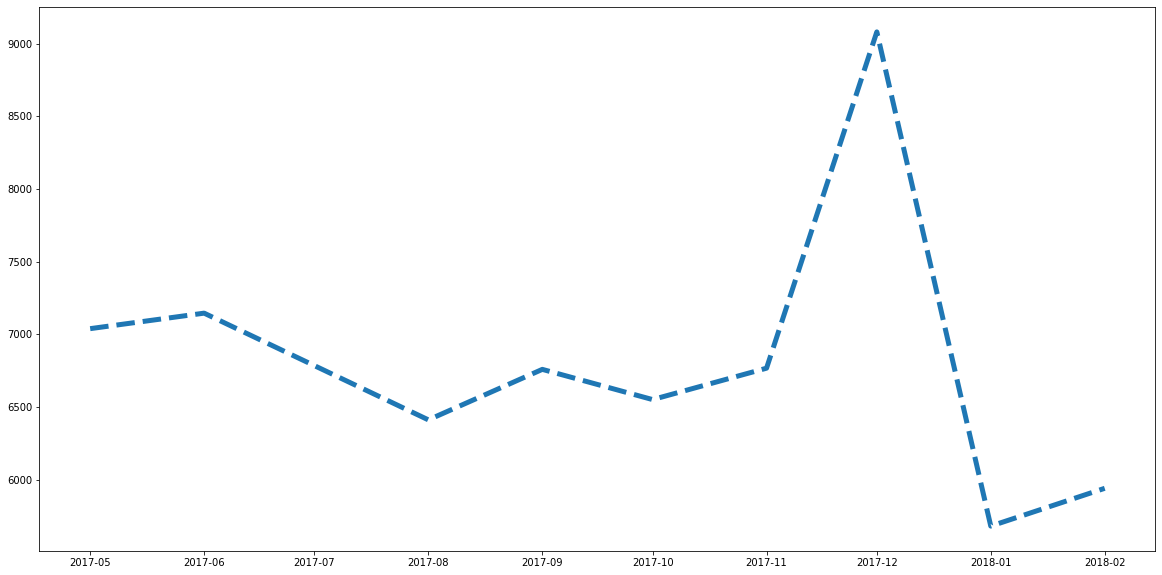

In [88]:
rcParams['lines.linewidth'] = 5
rcParams['lines.linestyle'] = '--'
data = np.random.randn(50)
plt.plot(ddff['SALES'])

{'boxes': [<matplotlib.lines.Line2D at 0x7f5168d0c210>],
 'caps': [<matplotlib.lines.Line2D at 0x7f5168d04290>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5168cdf2d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5168d04d50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5168d0c7d0>,
  <matplotlib.lines.Line2D at 0x7f5168d0cd10>]}

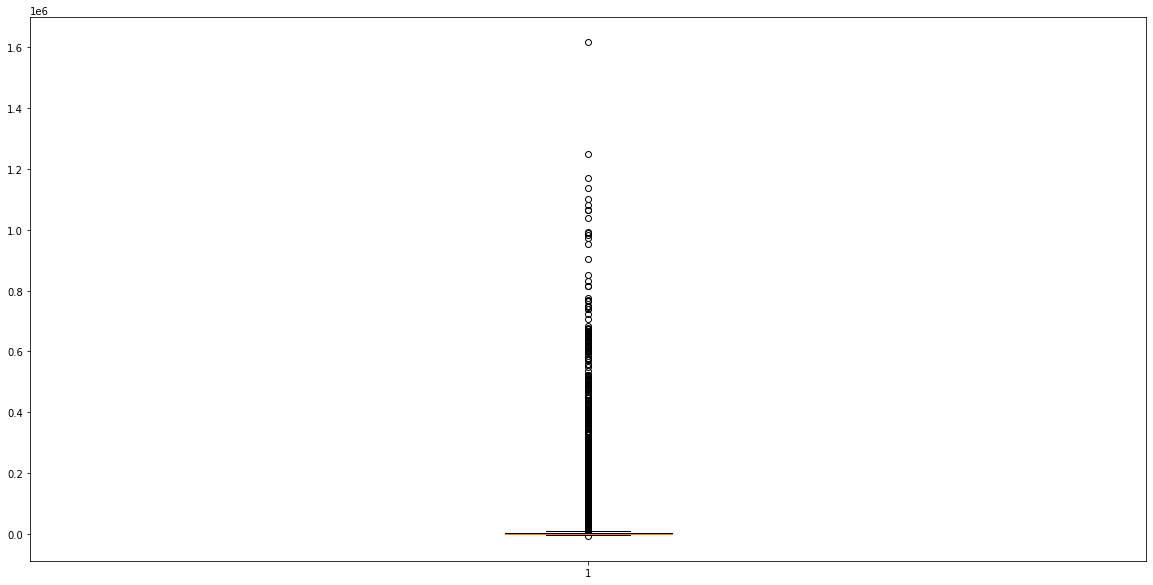

In [89]:
plt.boxplot(df_train.SALES)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


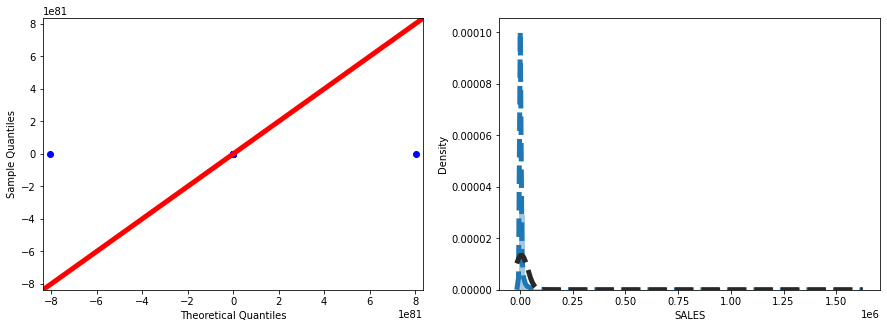

In [90]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
sm.qqplot(df_train.SALES, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(df_train.SALES, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

In [91]:
df_train.index = df_train['DATE']
df_train.drop('DATE', 1, inplace=True)
df_test.index = df_test['DATE']
df_test.drop('DATE', 1, inplace=True)
df_train

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,CONTRAGENT,ARTICLE_CODE,SALES,STORE_SALES,ARTICLE_GROUP_M_0,ARTICLE_GROUP_M_1,ARTICLE_GROUP_M_2,ARTICLE_GROUP_M_3,ARTICLE_GROUP_M_4,ARTICLE_GROUP_M_5,ARTICLE_GROUP_M_6,ARTICLE_GROUP_M_7
DATE,,,,,,,,,,,,
2017-05-01,428.843977,45.787540,0.0,1.0,0,0,0,0,0,0,0,1
2017-10-01,14685.747126,1205.985003,250.0,0.0,0,0,0,0,0,1,0,0
2017-10-01,428.843977,113.368068,0.0,11.0,1,0,0,0,0,0,0,0
2017-10-01,700.306782,324.452775,0.0,2.0,1,0,0,0,0,0,0,0
2017-10-01,700.306782,6.232739,0.0,1.0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,700.306782,110.035852,0.0,2.0,1,0,0,0,0,0,0,0
2018-02-01,2999.893617,45.787540,0.0,2.0,0,0,1,0,0,0,0,0
2018-02-01,20790.981925,87928.353866,66460.0,212.0,1,0,0,0,0,0,0,0


In [92]:
# Удаляем данные для декабря 2017 и января 2018
new_df_train = df_train.loc[(df_train.index !='2017-12-01')&(df_train.index !='2018-01-01')]
new_df_train

,CONTRAGENT,ARTICLE_CODE,SALES,STORE_SALES,ARTICLE_GROUP_M_0,ARTICLE_GROUP_M_1,ARTICLE_GROUP_M_2,ARTICLE_GROUP_M_3,ARTICLE_GROUP_M_4,ARTICLE_GROUP_M_5,ARTICLE_GROUP_M_6,ARTICLE_GROUP_M_7
DATE,,,,,,,,,,,,
2017-05-01,428.843977,45.787540,0.0,1.0,0,0,0,0,0,0,0,1
2017-10-01,14685.747126,1205.985003,250.0,0.0,0,0,0,0,0,1,0,0
2017-10-01,428.843977,113.368068,0.0,11.0,1,0,0,0,0,0,0,0
2017-10-01,700.306782,324.452775,0.0,2.0,1,0,0,0,0,0,0,0
2017-10-01,700.306782,6.232739,0.0,1.0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,700.306782,110.035852,0.0,2.0,1,0,0,0,0,0,0,0
2018-02-01,2999.893617,45.787540,0.0,2.0,0,0,1,0,0,0,0,0
2018-02-01,20790.981925,87928.353866,66460.0,212.0,1,0,0,0,0,0,0,0


In [93]:
# Применение стандартизации и разбиение оучающего датасета на train и valid
target = 'SALES'
X = new_df_train.drop('SALES', 1)
Y = new_df_train[target]

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.33, random_state=42)

In [94]:
df_test.drop('SALES',1, inplace=True)
X_test = scaler.transform(df_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Применение Пуассоновского Беггинга

In [95]:
from numpy.core.records import array
def PoissonRandomForestRegressor (X_train:array, Y_train:array, X_test:array, params:dict, n: int)->list:
    """
    The function implements the Random Forest Regressor on a Poisson Bootstrap sample.
    """

    #Import libraries
    import itertools as it
    import pandas as pd
    import numpy as np
    from sklearn.tree import DecisionTreeRegressor

    # Function implementation of Poisson bootstrap sampling.
    def poiss(df):
        """
        Function implementation of Poisson bootstrap sampling.
        """
        poisson = np.random.poisson(size = len(df))
        new_df = []
        for ind, cnt in enumerate(poisson):
            if cnt != 0:
                new_df += it.repeat(ind, cnt)
        df_poiss = df.loc[new_df,:]
        return df_poiss

    # Connecting arrays to a DataFrame
    X, Y = pd.DataFrame(X_train), pd.DataFrame(Y_train).reset_index(drop=True)
    new_df = pd.concat([X,Y], axis=1)

    # The cycle of learning the DecisionTreeRegressor model and predicting the target variable of the test sample.
    best_models = []
    for _ in range(1, n+1):
        
        new_df_train = poiss(new_df)
        X, Y = new_df_train.iloc[:,:-1], new_df_train.iloc[:,-1]
        X, Y = X.to_numpy(), Y.to_numpy()
        clf = DecisionTreeRegressor(**params)
        clf.fit(X,Y)
        result = clf.predict(X_test)
        best_models.append(result)
        
    # Let's sum up all the elements of the list by index.
    results = np.asarray(best_models).sum(axis=0)

    # We determine the average value for each index of the array.
    fin_res = [j/n for j in results]
    return fin_res

In [96]:
outcome = PoissonRandomForestRegressor(X_train, y_train, X_valid, {'max_depth':9, 'min_samples_split':4}, 200)
print("train_metric:", metric(y_valid, outcome))

train_metric: 25.306738713925093


In [97]:
df_test['SALES'] = PoissonRandomForestRegressor(X_train, y_train, X_test, {'max_depth':9, 'min_samples_split':4}, 200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
df_all = pd.concat([new_df_train, df_test])
df_all = df_all.sort_index()
df_all

,CONTRAGENT,ARTICLE_CODE,SALES,STORE_SALES,ARTICLE_GROUP_M_0,ARTICLE_GROUP_M_1,ARTICLE_GROUP_M_2,ARTICLE_GROUP_M_3,ARTICLE_GROUP_M_4,ARTICLE_GROUP_M_5,ARTICLE_GROUP_M_6,ARTICLE_GROUP_M_7
DATE,,,,,,,,,,,,
2017-04-01,3227.4,2999.89,2764.410669,0.0,1,0,0,0,0,0,0,0
2017-04-01,1814.98,999.537,717.258402,0.0,0,0,0,0,0,0,0,1
2017-04-01,26783.5,26767.1,20214.017993,0.0,0,0,0,0,0,0,0,1
2017-04-01,914.152,124.081,106.775199,0.0,0,0,0,0,0,0,0,1
2017-04-01,2551.32,2446.09,2099.309365,0.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,327.089,324.453,0.000000,1.0,0,0,0,0,0,0,0,1
2018-02-01,327.089,6.23274,0.000000,5.5,0,0,0,0,0,0,0,1
2018-02-01,1013.68,2.29422,0.000000,3.0,0,0,0,0,0,0,0,1


# Задача 2:
- Проведите аналитику полученных данных
- Подготовьте данные для модели классификации
- Обучите модель классификации и осуществите прогноз для отложенной выборки с учетомо перекоса в данных TARGET
- Оцените качество модели с помощью функции f1_score

In [104]:
df_2 = pd.read_csv(r'/content/drive/MyDrive/Elbrus/data_classification_for_task.csv')
df_2

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [159]:
df_2.TARGET.value_counts()

1    165
0    138
Name: TARGET, dtype: int64

In [105]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AGE         303 non-null    int64  
 1   GENDER      303 non-null    int64  
 2   FEATURE_1   303 non-null    int64  
 3   FEATURE_2   303 non-null    int64  
 4   FEATURE_3   303 non-null    int64  
 5   FEATURE_4   303 non-null    int64  
 6   FEATURE_5   303 non-null    int64  
 7   FEATURE_6   303 non-null    int64  
 8   FEATURE_7   303 non-null    int64  
 9   FEATURE_8   303 non-null    float64
 10  FEATURE_9   303 non-null    int64  
 11  FEATURE_10  303 non-null    int64  
 12  FEATURE_11  303 non-null    int64  
 13  TARGET      303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [106]:
df_2.isnull().sum() # Пропущенные значения

AGE           0
GENDER        0
FEATURE_1     0
FEATURE_2     0
FEATURE_3     0
FEATURE_4     0
FEATURE_5     0
FEATURE_6     0
FEATURE_7     0
FEATURE_8     0
FEATURE_9     0
FEATURE_10    0
FEATURE_11    0
TARGET        0
dtype: int64

In [107]:
# Разбиваем признак AGУ (Возраст) на пожилых и работоспособных
df_2.AGE = df_2.AGE.apply(lambda x: 0 if x < 60 else 1)
df_2

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
0,1,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,0,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,0,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,0,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,0,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,0,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,1,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,0,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [109]:
fvalue, pvalue = stats.f_oneway(df_2['FEATURE_5'], df_2['TARGET'])
print(fvalue, pvalue)

0.15704954861255507 0.6920275427852707


In [110]:
target = 'TARGET' # Обозначает целевую переменную

In [118]:
X_2 = df_2.drop(['TARGET', 'FEATURE_5', 'FEATURE_11', 'FEATURE_10', 'FEATURE_3', 'FEATURE_4'], 1).to_numpy()
Y_2 = df_2[target].to_numpy()
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_2, Y_2, test_size=0.33, random_state=42)

## Применение логистической регрессии

In [191]:
lg = LogisticRegression(warm_start=True)
lg.fit(X_train_2, y_train_2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(warm_start=True)

In [192]:
pred = lg.predict(X_valid_2)
print(f1_score(y_valid_2,pred, average = 'micro'))
print(lg.predict(X_valid_2))

0.87
[0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1
 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0]
